In [48]:
# ECE60146 HW5
# Zhengxin Jiang
# jiang839

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import seaborn as sn 
import random
import json

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as tvt
from torch.utils.data import DataLoader

import cv2


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Function for preparing the training data
def prepData(rawDataDir, hwDataDir):
    
    coco = COCO('{}/annotations/instances_train2014.json'.format(rawDataDir)) 
    
    bbox_list_train = []
    bbox_list_val = []
    
    catIds = coco.getCatIds(catNms=['bus','cat','pizza'])
    
    for catCount,catId in enumerate(catIds):
        
        ImgIds = coco.getImgIds(catIds=catId)
        random.shuffle(ImgIds)
        
        imgCount = 0
        for imgId in ImgIds:
            
            coco_img = coco.loadImgs(imgId)[0]
            imgName = coco_img['file_name']
            img = Image.open(rawDataDir+'/'+imgName)
            
            annId = coco.getAnnIds(imgIds=coco_img['id'], catIds=catId, iscrowd=None)
            ann = coco.loadAnns(annId)[0]
            
            if ann['area'] < 4000:
                continue
            
            bbox = ann['bbox']
            
            
            resize_ratio = (256/img.size[0], 256/img.size[1])
            bbox_resized = np.zeros(4)
            bbox_resized[0] = bbox[0]*resize_ratio[0]
            bbox_resized[2] = bbox[2]*resize_ratio[0]
            bbox_resized[1] = bbox[1]*resize_ratio[1]
            bbox_resized[3] = bbox[3]*resize_ratio[1]
            bbox_resized[2:] += bbox_resized[:2]        # change the format to [x1, y1, x2, y2]
            bbox_resized[2:] -= 1e-3
            bbox_resized[:2] += 1e-3                    # let bbox reside in (0,1)
            
            if img.mode != "RGB":
                img = img.convert(mode="RGB")
            img = img.resize((256, 256), Image.BOX)
            
            
            # Save training and validation images
            if imgCount<1400:
                
                imgNewName = str(catCount*1400+imgCount) + '.jpg'
                fp = open('{}/train/{}'.format(hwDataDir, imgNewName), 'w')
                img.save(fp)
                bbox_list_train.append(bbox_resized)
                
            elif imgCount<1900:
                
                imgNewName = str(catCount*500+imgCount-1400) + '.jpg'
                fp = open('{}/val/{}'.format(hwDataDir, imgNewName), 'w')
                img.save(fp)
                bbox_list_val.append(bbox_resized)
                
            else:
                break
                
            imgCount += 1
    
    np.save('{}/train/bbox'.format(hwDataDir), bbox_list_train)
    np.save('{}/val/bbox'.format(hwDataDir), bbox_list_val)            
                
    return



# The Dataset class for hw5
class hwDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, tasktype):
        super().__init__()
        
        if tasktype == 'training':
            self.root = os.path.join(root, 'train').replace("\\","/")
            self.bbox = np.load(os.path.join(self.root, 'bbox.npy').replace("\\","/"))
            self.classlen = 1400
            
        if tasktype == 'validation':
            self.root = os.path.join(root, 'val').replace("\\","/")
            self.bbox = np.load(os.path.join(self.root, 'bbox.npy').replace("\\","/"))
            self.classlen = 500
            
        
    def __len__(self):
        return self.classlen * 3
        
    def __getitem__(self, index):
        name = str(index)+'.jpg'
        
        img = Image.open(os.path.join(self.root, name).replace("\\","/"))
        
        tr = tvt.Compose([
            tvt.ToTensor(),
            tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        img_tensor = tr(img)
        
        label = index // self.classlen
        
        bbox_tensor = torch.tensor(self.bbox[index]/256)
        
        return img_tensor, bbox_tensor.float(), label

    
# The Resnet block with skip connection 
class ResnetBlock(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(ResnetBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
            
            
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn(self.conv(x)))
        out = self.bn(self.conv(out))
        out += identity   #skip connection
        out = F.relu(out)
        
        return out
    
    
class HW5Net(nn.Module):
    
    def __init__(self, input_nc, ngf=8, n_blocks=4):
        super(HW5Net, self).__init__()
        
        # The first conv layer
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 nn.BatchNorm2d(ngf),
                 nn.ReLU(True)]
        
        # Add downsampling layers
        n_downsampling = 5
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size=3, stride=2, padding=1), 
                      nn.BatchNorm2d(ngf*mult*2), 
                      nn.ReLU(True)]
    
        # My own ResNet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf*mult, ngf*mult)]
        self.model = nn.Sequential(*model)
        
        wh = int(256/mult)
        # The classification head
        class_head = [nn.Flatten(),
                      nn.Linear(ngf*mult*wh*wh, 1024),
                      nn.ReLU(True),
                      nn.Linear(1024, 512), 
                      nn.ReLU(True),
                      nn.Linear(512, 3)]
        self.class_head = nn.Sequential(*class_head)
        
        # The bounding box regression head
        bbox_head = [nn.Flatten(),
                     nn.Linear(ngf*mult*wh*wh, 1024),
                     nn.ReLU(True),
                     nn.Linear(1024, 512), 
                     nn.ReLU(True),
                     nn.Linear(512, 4)]
        self.bbox_head = nn.Sequential(*bbox_head)
        
    def forward(self, x):
        ft = self.model(x)
        cls = self.class_head(ft)
        bbox = self.bbox_head(ft)
        
        return cls, bbox

    
def drawBBox(imgnum, label, predicted_label, gt, predict):
    
    gt = gt*256
    predict = predict*256
    
    class_name = ['bus', 'cat', 'pizza']
    
    img = cv2.imread('D:/coco/hw5/val/{}.jpg'.format(imgnum))
    img = cv2.rectangle(img, (int(gt[0]), int(gt[1])), (int(gt[2]), int(gt[3])), (36, 255, 12), 2)
    img = cv2.rectangle(img, (int(predict[0]), int(predict[1])), (int(predict[2]), int(predict[3])), (36, 12, 255), 2)
    
    img = cv2.putText(img, class_name[label], (int(gt[0]), int(gt[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36, 255, 12), 2)
    img = cv2.putText(img, class_name[predicted_label], (int(predict[0]), int(predict[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36, 12, 255), 2)
    
    cv2.imwrite('{}.jpg'.format(imgnum), img)
    
    return img
    
    

cuda:0


In [6]:
rawDataDir = 'D:/coco/train2014'
hwDataDir = 'D:/coco/hw5'

prepData(rawDataDir, hwDataDir)

loading annotations into memory...
Done (t=10.70s)
creating index...
index created!


In [3]:
root = 'D:/coco/hw5'

traindataset = hwDataset(root, 'training')
train_data_loader = DataLoader(traindataset, batch_size=4, num_workers=0, shuffle=True)

In [33]:
#### Training

net = HW5Net(3)
net = net.to(device)

criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.99))

for epoch in range(50):
    running_loss_labeling = 0.0
    running_loss_regression = 0.0
    
    for i, data in enumerate(train_data_loader):
        inputs, bbox_gt, labels = data
        
        inputs = inputs.to(device)
        bbox_gt = bbox_gt.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss_labeling = criterion1(outputs[0], labels)
        loss_labeling.backward(retain_graph=True)
#         loss_regression = criterion2(outputs[1], bbox_gt)
        loss_regression = torchvision.ops.complete_box_iou_loss(bbox_gt, outputs[1], reduction='mean')
        loss_regression.backward()
        optimizer.step()
        
        running_loss_labeling += loss_labeling.item()
        running_loss_regression += loss_regression.item()
        
        if (i+1) % 100 == 0:
            print("[ epoch : %d, batch : %5d] loss_label : %.4f" % (epoch + 1, i + 1, running_loss_labeling / 100))
            running_loss_labeling = 0.0
            print("[ epoch : %d, batch : %5d] loss_reg : %.4f" % (epoch + 1, i + 1, running_loss_regression / 100))
            running_loss_regression = 0.0
            
    

[ epoch : 1, batch :   100] loss_label : 1.0963
[ epoch : 1, batch :   100] loss_reg : 1.0169
[ epoch : 1, batch :   200] loss_label : 0.9179
[ epoch : 1, batch :   200] loss_reg : 1.0012
[ epoch : 1, batch :   300] loss_label : 0.8211
[ epoch : 1, batch :   300] loss_reg : 1.0934


KeyboardInterrupt: 

In [27]:
num_layers = len(list(net.parameters()))
print(num_layers)

52


In [27]:
torch.save(net.state_dict(), 'mse.pth')

In [6]:
net = HW5Net(3)
net = net.to(device)
# load trained parameters 
net.load_state_dict(torch.load('mse.pth', map_location=torch.device(device))) 



<All keys matched successfully>

In [17]:
valdataset = hwDataset(root, 'validation')
val_data_loader = DataLoader(valdataset, batch_size=5, num_workers=0, shuffle=False)

In [51]:
# Validation
cm = torch.zeros(3,3)
true_count = 0
total_iouloss = 0

# no grad for inference
with torch.no_grad():
    for i, data in enumerate(val_data_loader):
        
        inputs, bbox_gt, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        bbox_gt = bbox_gt.to(device)
        outputs = net(inputs)
        
        # The predicted labels
        max_vals, predicted_labels = torch.max(outputs[0], 1)
        predicted_bbox = outputs[1]
        
        total_iouloss += torchvision.ops.complete_box_iou_loss(bbox_gt, predicted_bbox, reduction='sum')
        
        for j in range(len(labels)):
            cm[labels[j]][predicted_labels[j]] += 1
            if labels[j] == predicted_labels[j]:
                true_count += 1
        
        # save bbox for visualization
        if i == 0:
            for j in range(3):
                img = drawBBox(j, labels[j], predicted_labels[j], bbox_gt[j], predicted_bbox[j])
                
        if i == 100:
            for j in range(3):
                img = drawBBox(i*5+j, labels[j], predicted_labels[j], bbox_gt[j], predicted_bbox[j])
                
        if i == 200:
            for j in range(3):
                img = drawBBox(i*5+j, labels[j], predicted_labels[j], bbox_gt[j], predicted_bbox[j])
            

mean_iouloss = total_iouloss/1500
acc = true_count/1500
print(acc)
print(mean_iouloss)

0.8926666666666667
tensor(0.5870, device='cuda:0')


<Axes: title={'center': 'Confusion Matrix of Validation (CIoU), acc=0.907, mean IoU=0.565'}>

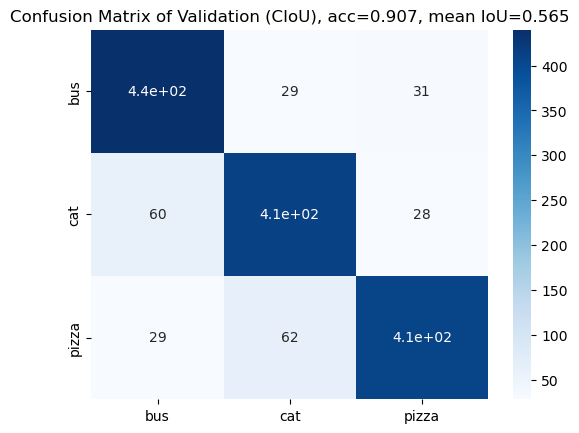

In [38]:
plt.figure()
plt.title("Confusion Matrix of Validation (CIoU), acc=%.3f, mean IoU=%.3f" % (acc, mean_iouloss)) 
sn.heatmap(cm, annot=True, cmap="Blues",xticklabels=['bus','cat','pizza'], yticklabels=['bus','cat','pizza'])

In [35]:
plt.figure()
plt.show(img)

<Figure size 640x480 with 0 Axes>

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 640x480 with 0 Axes>